In [1]:
import pandas as pd
from pandas import Grouper, DataFrame
from pandas.plotting import autocorrelation_plot

import numpy as np
import os
from datetime import datetime
from typing import List

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

### Constantes

In [2]:
DIR_DATASET: str = os.path.join('datasets', 'dados-gerados')

DATASET_OEC_MPME = os.path.join(DIR_DATASET,  'oec_mpme.csv')

DAT_CORRENTE = datetime.today().strftime("%Y-%m-%d")

In [3]:
df_oec_mpme = pd.read_csv(DATASET_OEC_MPME, sep=';', decimal=',', parse_dates=True)

In [4]:
df_oec_mpme.index = pd.DatetimeIndex(df_oec_mpme.data_base)

In [5]:
df_oec_mpme["ano_mes"] = pd.DatetimeIndex(df_oec_mpme.data_base).strftime('%Y-%m')

In [6]:
df_oec_mpme.head()

,ano,mes,data_base,desembolso,vendas,aprovacao,ind_atv_econ,tx_pre_prazo_medio,A_PRE_12,A_PRE_24,A_PRE_36,A_PRE_60,custo_bndes,dif_custo_bndes_mercado,ano_mes
data_base,,,,,,,,,,,,,,,
2009-10-01,2009,10,2009-10-01,1388.5,13123.0,1437.057832,129.78,12.796206,9.723852,11.376501,12.213310,12.824550,4.0,-8.796206,2009-10
2009-11-01,2009,11,2009-11-01,1339.9,13219.0,1497.107343,130.01,13.062494,9.969168,11.560462,12.282385,12.869093,4.0,-9.062494,2009-11
2009-12-01,2009,12,2009-12-01,1259.6,15104.0,1580.255803,131.36,13.233439,9.984419,11.687233,12.488141,13.121518,4.0,-9.233439,2009-12
2010-01-01,2010,1,2010-01-01,1682.7,11569.0,1853.163058,133.50,13.156129,10.341847,11.944138,12.657941,13.269531,4.0,-9.156129,2010-01
2010-02-01,2010,2,2010-02-01,1160.7,9581.0,1774.880889,135.18,12.657825,10.452661,11.913480,12.576683,13.181880,4.0,-8.657825,2010-02


In [7]:
df_oec_mpme_desembolso = df_oec_mpme[['desembolso','ano','mes', 'ano_mes']]

In [8]:
desembolso = df_oec_mpme_desembolso[["desembolso"]].to_numpy().squeeze()
desembolso_time = df_oec_mpme_desembolso[["ano_mes"]].to_numpy().squeeze()

In [9]:
def run_sequence_plot_desembolso(x, y, title, xlabel="time", ylabel="valor desembolsado"):
    plt.figure(figsize=(20,10))
    plt.xticks(rotation='vertical')
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(2))
    plt.plot(x, y, 'k-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.3);

---
## DESEMBOLSO

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 0 ns


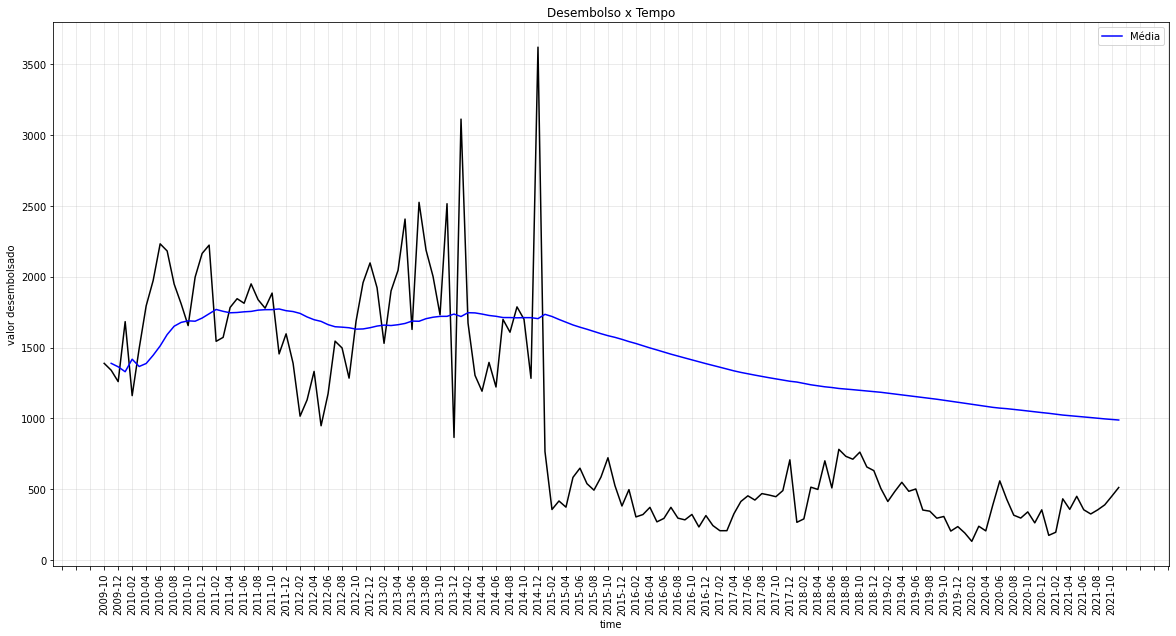

In [13]:
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo')
average_desembolso = [np.average(desembolso[:x]) for x in range(len(desembolso))]
plt.plot(desembolso_time, average_desembolso, 'b', label=f"Média")
plt.legend()

### Agrupamento por ano

<AxesSubplot:xlabel='ano', ylabel='desembolso'>

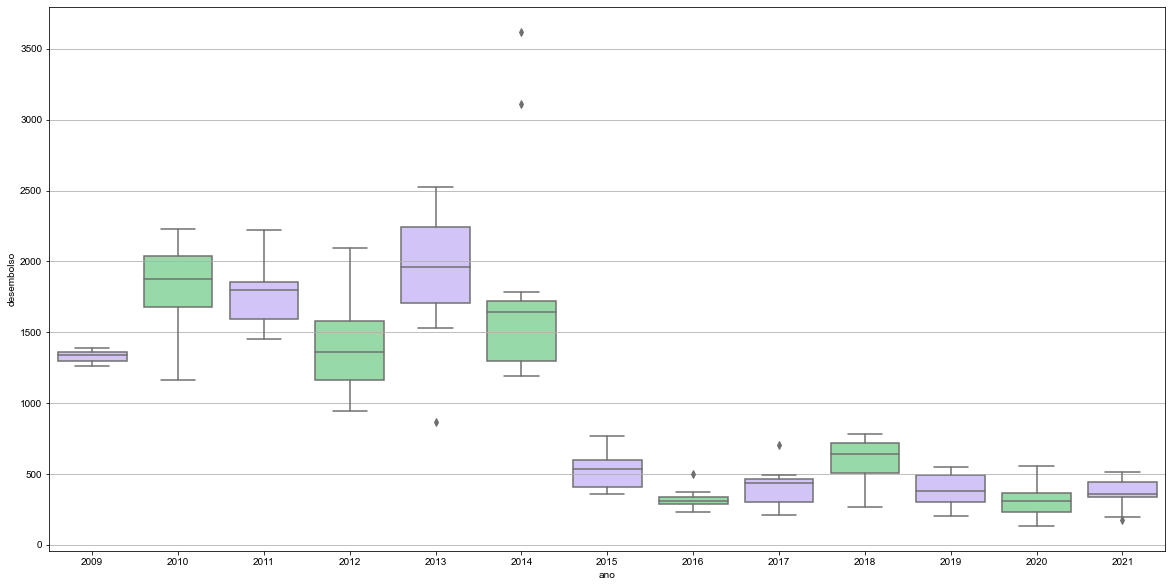

In [9]:
fig, ax = plt.subplots(figsize=(20, 10)) 
ax.yaxis.grid(True)
ax.xaxis.grid(False) 

sns.set_theme(style="white", palette="pastel")
sns.boxplot(x="ano", y="desembolso", palette=["m", "g"], data=df_oec_mpme_desembolso, ax=ax)

#### Histogram

<AxesSubplot:>

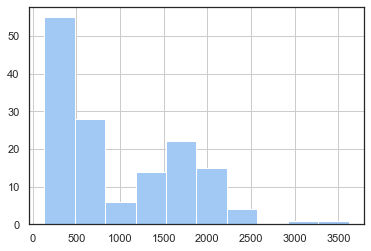

In [10]:
ser_desembolso = df_oec_mpme.desembolso
ser_desembolso.hist()

<AxesSubplot:ylabel='Density'>

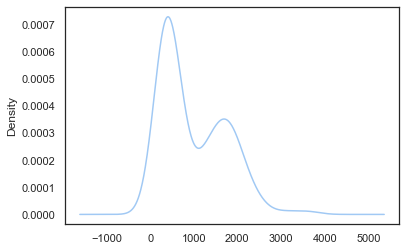

In [11]:
ser_desembolso.plot(kind='kde')

## Moving Average

In [45]:
def moving_average(observations, window=3):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    return cumulative_sum[window - 1:] / window

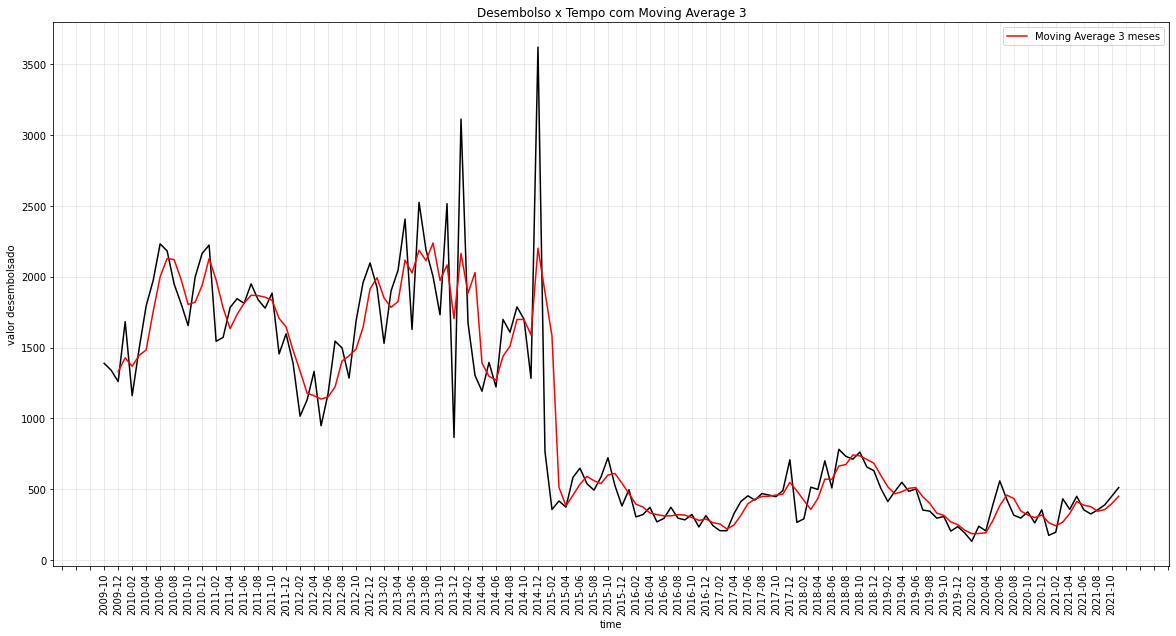

In [46]:
### Moving Average com Janela 3
window_ma_desembolso = 3
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

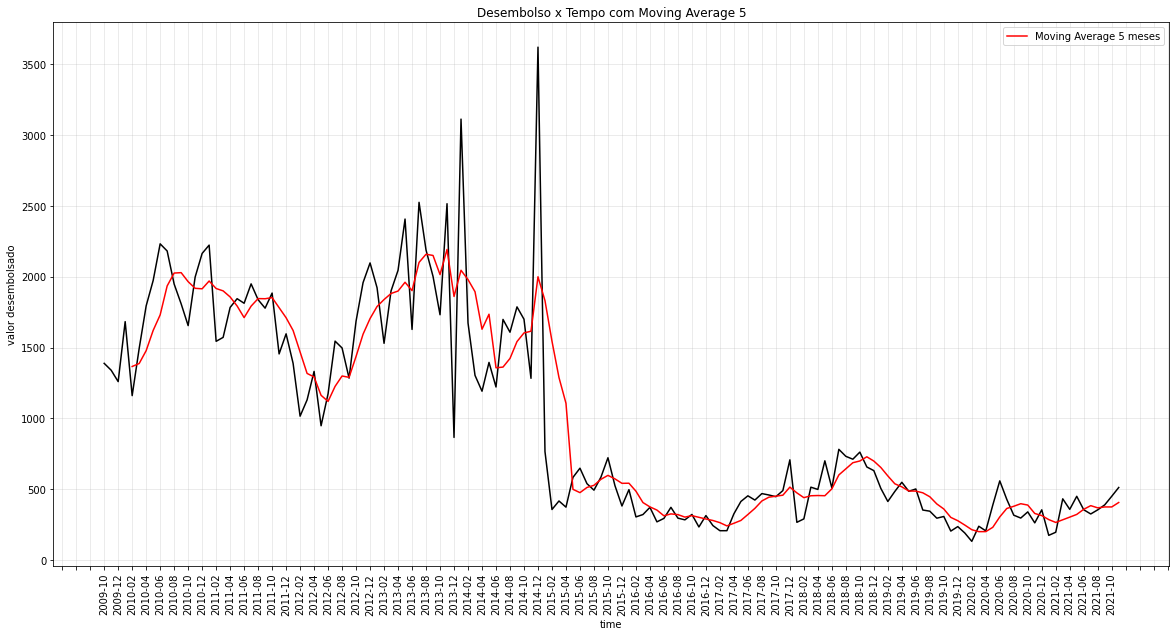

In [47]:
### Moving Average com Janela 5
window_ma_desembolso = 5
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

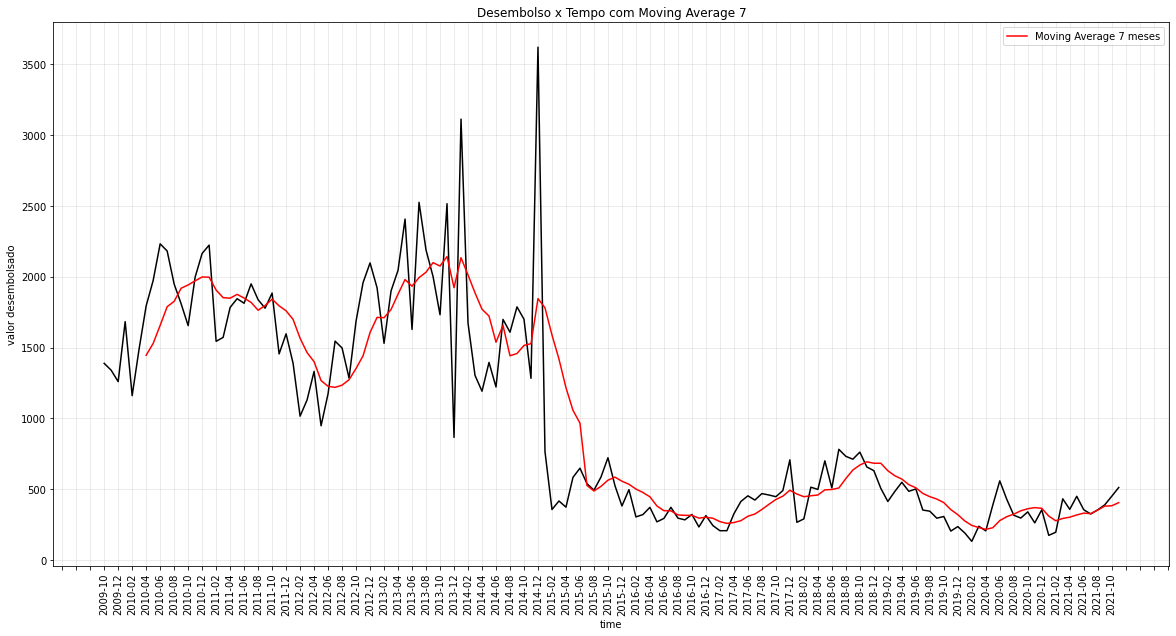

In [48]:
### Moving Average com Janela 7
window_ma_desembolso = 7
desembolso_ma = moving_average(desembolso, window_ma_desembolso)
run_sequence_plot_desembolso(desembolso_time, desembolso, f'Desembolso x Tempo com Moving Average {window_ma_desembolso}')
plt.plot(desembolso_time[window_ma_desembolso - 1:], desembolso_ma, 'r', label=f"Moving Average {window_ma_desembolso} meses")
plt.legend();

#### Decomposição

In [17]:
desembolso_decomposition = seasonal_decompose(x=desembolso, model='multiplicative', period=12)

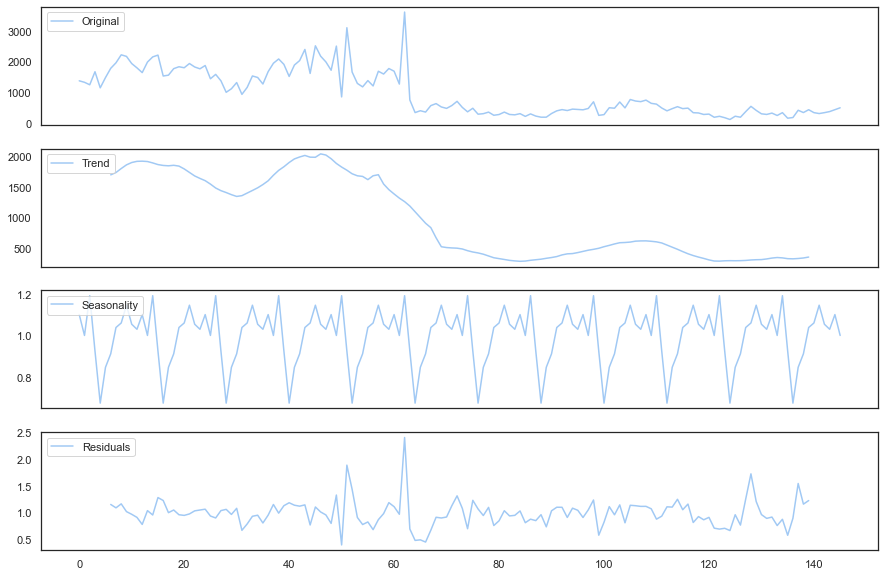

In [19]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(desembolso, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(desembolso_decomposition.trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(desembolso_decomposition.seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(desembolso_decomposition.resid, label='Residuals')
axes[3].legend(loc='upper left');

## Custo BNDES 

In [23]:
df_oec_mpme_custo = df_oec_mpme[['tx_pre_prazo_medio', 'custo_bndes', 'dif_custo_bndes_mercado', 'ano_mes']]

In [24]:
custo = df_oec_mpme_custo[["custo_bndes"]].to_numpy().squeeze()
custo_mercado = df_oec_mpme_custo[["tx_pre_prazo_medio"]].to_numpy().squeeze()
dif_custo_mercado = df_oec_mpme_custo[["dif_custo_bndes_mercado"]].to_numpy().squeeze()
custo_time = df_oec_mpme_custo[["ano_mes"]].to_numpy().squeeze()

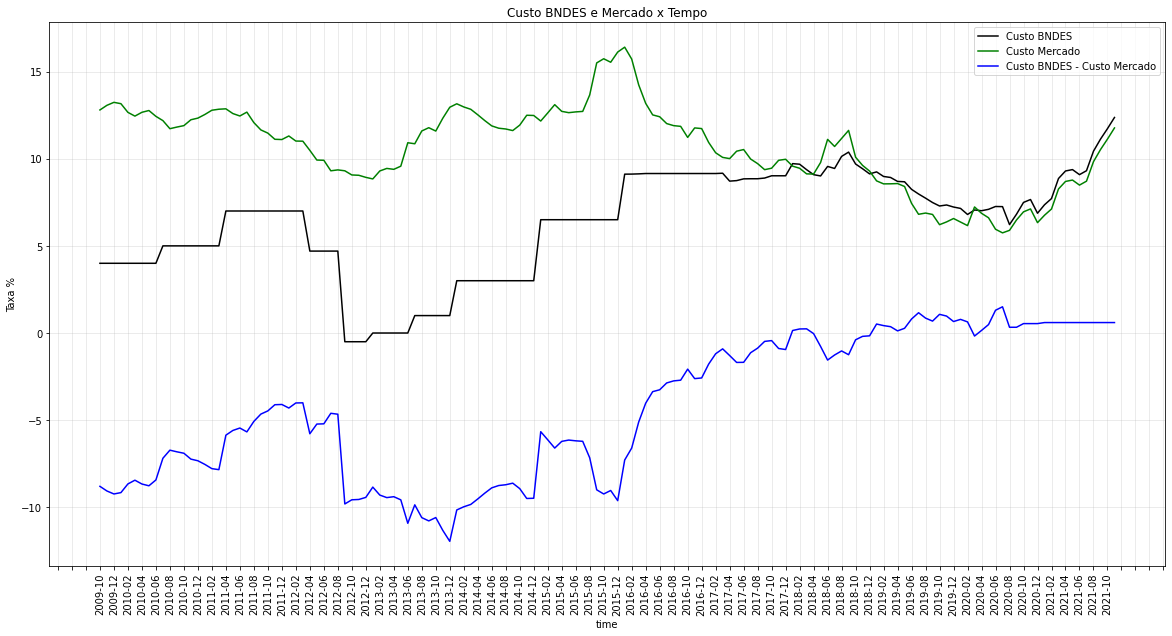

In [25]:
run_sequence_plot_desembolso(custo_time, custo, f'Custo BNDES e Mercado x Tempo', ylabel='Taxa %')
plt.plot(custo_time, custo_mercado, 'g', label=f"Mercado")
plt.plot(custo_time, dif_custo_mercado, 'b', label=f"Diferença BNDES x Mercado")
plt.legend(['Custo BNDES', 'Custo Mercado', 'Custo BNDES - Custo Mercado']);

## Stationary

In [14]:
result_stationary = adfuller(desembolso)
print(result_stationary)
pvalue = result_stationary[1]
if pvalue < 0.05:
    print('Desembolso é uma série Estacionária')
else:
    print('Desembolso Não é uma série Estacionária')

(-1.3937257817155209, 0.5852803339071966, 11, 134, {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}, 1935.6512939975096)
Desembolso Não é uma série Estacionária


In [20]:
#Verificando se a diferença entre valores é uma série estacionária
diff_desembolso = np.diff(desembolso)
diff_desembolso_time = desembolso_time[1:] # diff retira o primeiro item
average_diff_desembolso = [np.average(diff_desembolso[:x]) for x in range(len(diff_desembolso))]

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


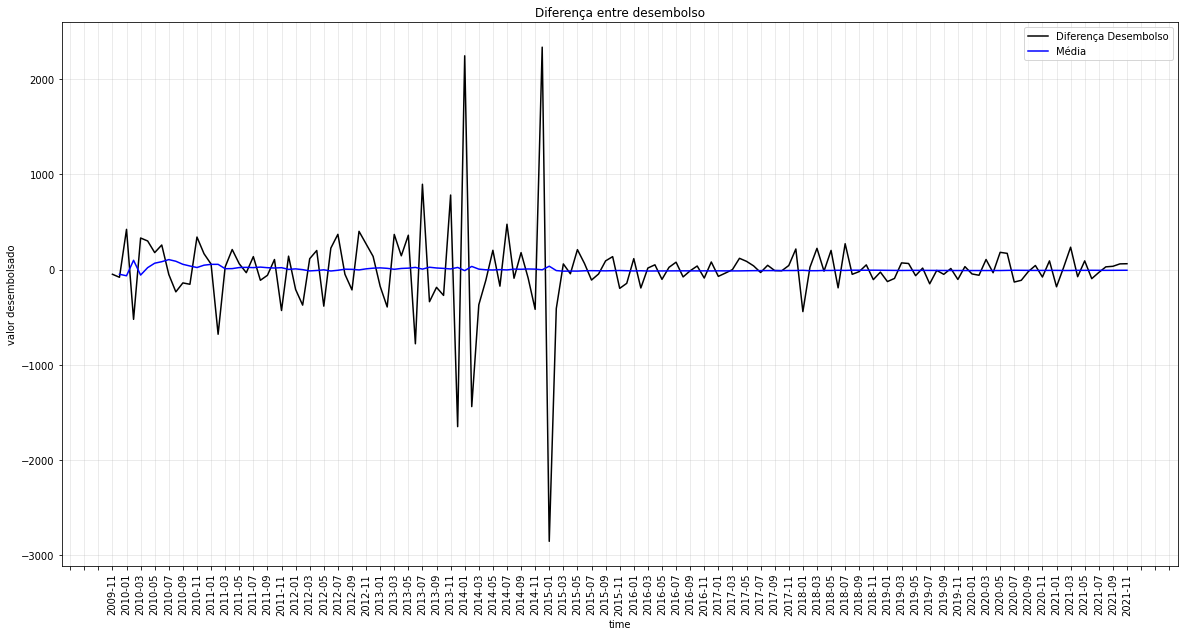

In [21]:
run_sequence_plot_desembolso(diff_desembolso_time, diff_desembolso, f'Diferença entre desembolso')
plt.plot(diff_desembolso_time, average_diff_desembolso, 'b', label=f"Média")
plt.legend(['Diferença Desembolso', 'Média'])

In [22]:
result_stationary = adfuller(diff_desembolso)
print(result_stationary)
pvalue = result_stationary[1]
if pvalue < 0.05:
    print('Diferença de desembolso é uma série Estacionária')
else:
    print('Diferença de desembolso Não é uma série Estacionária')

(-4.092690169383666, 0.0009958237478327697, 10, 134, {'1%': -3.480118600110386, '5%': -2.8833618426136196, '10%': -2.578407034974382}, 1920.5398353633752)
Diferença de desembolso é uma série Estacionária


> Se com um passo conseguimos transformar a série em estacionária então poderemos aplicar modelos estatísticos que utilizem a diferença com um passo (parametro).
Modelos que utilizam diferença com adionais de complexidade incremental ARIMA (diferença), SARIMA (sazonalidade), SARIMAX (variáveis exógenas).

## Correlation

In [14]:
df_oec_mpme_correlation = df_oec_mpme[['desembolso', 'vendas', 'aprovacao',
       'ind_atv_econ', 'tx_pre_prazo_medio', 'A_PRE_12', 'A_PRE_24',
       'A_PRE_36', 'A_PRE_60', 'custo_bndes', 'dif_custo_bndes_mercado']]

In [16]:
df_oec_mpme_correlation.corr()

,desembolso,vendas,aprovacao,ind_atv_econ,tx_pre_prazo_medio,A_PRE_12,A_PRE_24,A_PRE_36,A_PRE_60,custo_bndes,dif_custo_bndes_mercado
desembolso,1.000000,0.785499,0.883498,0.569277,0.348548,0.297424,0.336768,0.341706,0.329946,-0.738535,-0.744364
vendas,0.785499,1.000000,0.751808,0.576453,0.095303,0.043618,0.087508,0.086367,0.065025,-0.593713,-0.492160
aprovacao,0.883498,0.751808,1.000000,0.516675,0.327963,0.267271,0.308466,0.313169,0.300835,-0.741419,-0.734661
ind_atv_econ,0.569277,0.576453,0.516675,1.000000,0.182848,0.188560,0.196015,0.180862,0.143832,-0.603863,-0.549939
tx_pre_prazo_medio,0.348548,0.095303,0.327963,0.182848,1.000000,0.932856,0.967582,0.977434,0.977393,-0.150120,-0.685184
A_PRE_12,0.297424,0.043618,0.267271,0.188560,0.932856,1.000000,0.987941,0.971381,0.943064,-0.119773,-0.624247
A_PRE_24,0.336768,0.087508,0.308466,0.196015,0.967582,0.987941,1.000000,0.995702,0.978939,-0.143018,-0.661324
A_PRE_36,0.341706,0.086367,0.313169,0.180862,0.977434,0.971381,0.995702,1.000000,0.993206,-0.138485,-0.663645
A_PRE_60,0.329946,0.065025,0.300835,0.143832,0.977393,0.943064,0.978939,0.993206,1.000000,-0.116783,-0.647634
custo_bndes,-0.738535,-0.593713,-0.741419,-0.603863,-0.150120,-0.119773,-0.143018,-0.138485,-0.116783,1.000000,0.822976


In [17]:
len(df_oec_mpme_correlation)

146

## Autocorrelation

In [10]:
diff_desembolso = np.diff(desembolso)

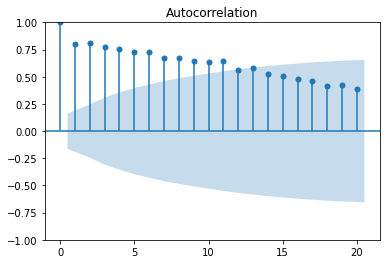

In [14]:
plot_acf(desembolso, lags=20)
plt.show()

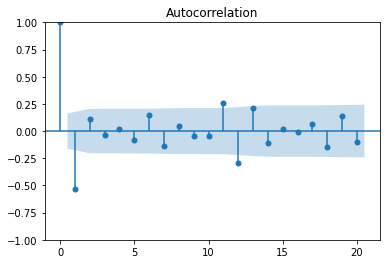

In [15]:
plot_acf(diff_desembolso, lags=20)
plt.show()

## Partial Autocorrelation
Busca garantir que um lag não será utilizado mais de uma vez, informando incorretame uma autorelação

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


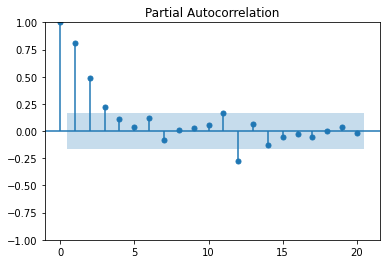

In [17]:
plot_pacf(desembolso, lags=20)
plt.show()

C:\Users\gdutr\miniconda3\envs\forecast\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


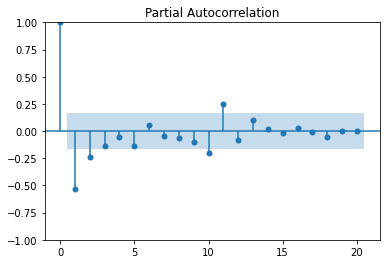

In [18]:
plot_pacf(diff_desembolso, lags=20)
plt.show()